# Acquisition

In [6]:
# import the required packages
import numpy as np 
import pandas as pd

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

# Case Overview

- A B2B company conducted an **acquisition campaign** in which they tried to convert leads into customers.
  In addition, they registered which leads eventually converted into profitable customers and which leads didn't.
    
    
- The **B2B** company also gathered information about the **characteristics of the leads**:
    
   
    a) The commercial dataset: this is a dataset which was bought from commercial vendors who are specialized in
       collecting data from companies such as revenue, net profit, cashflow, number of employees etc. 
       This data is often expensive and contains a lot of missing values.
    
    
    a) The web dataset: this is a dataset which was scraped from the web.
       This is a very cheap source of information but needs a lot of preprocessing since it is unstructured.
       Initially, it contained the textual data found on the website (if available) of each company. 
       In a next step, a text mining algorithm (Singular Value Decomposition) was used to convert this textual 
       data in 200 numerical variables (SVD_1, SVD_2, ..., SVD_200). 
       These variables somehow represent concepts which were found across all the
       websites and the values for these variables represent how much a company focused on this concept on its 
       website. This dataset also contains the Target variable which represents whether a company was converted 
       into a profitable customer or not.
      
- The B2B company wants to **build a model** that tries to find a relationship between the characteristics of the leads on the one hand and the probability of converting into a profitable customer on the other hand. This would allow the B2B company to **only target leads with a high probability of converting** into a profitable customer.

The following pictures gives a **quick overview** of the case:

<img src="./Data/acquisition_case_workflow.png" width="800">

The following picture visualizes how **Singular Value Decomposition** (**SVD**) works:

<img src="./data/lsi.png" width="500">

# 1. Data Exploration

In [7]:
# import web data
web_data = pd.read_csv("./data/web1.csv", encoding="latin1")

# import commercial data, but with NACE_code as a string variable to keep leading zero 
commercial_data = pd.read_csv("./data/commercial1.csv", encoding="latin1", dtype={'NACE_code': object})

In [8]:
# inspect the first three observations of the web data
web_data.head(3)

,URI,NAME,TARGET,_DOCUMENT_,_SVD_1,_SVD_2,_SVD_3,_SVD_4,_SVD_5,_SVD_6,...,_SVD_192,_SVD_193,_SVD_194,_SVD_195,_SVD_196,_SVD_197,_SVD_198,_SVD_199,_SVD_200,_SVDLEN_
0,file://C:\sas\small2\n2-1313http%3A--www.melis...,n2-1313http%3A--www.melisard.de-.txt.htm,0,1,0.390678,-0.118327,0.199925,-0.200753,0.053916,-0.104150,...,-0.013452,0.011185,-0.002033,0.005218,-0.007452,0.007244,-0.005440,0.012882,-0.000899,62.478443
1,file://C:\sas\small2\n2-1327http%3A--www.auto-...,n2-1327http%3A--www.auto-boehler.de-.txt.htm,0,2,0.463090,-0.121661,-0.149195,0.222979,-0.097737,0.000127,...,-0.066052,0.028640,0.020099,-0.013749,-0.006084,-0.004447,0.032138,0.020648,-0.009978,36.631883
2,file://C:\sas\small2\n2-1346http%3A--www.ac-me...,n2-1346http%3A--www.ac-metallteile.de-.txt.htm,0,3,0.425443,-0.192835,-0.162892,0.221980,0.106563,-0.120675,...,0.010257,0.006590,0.058038,0.016583,-0.005697,-0.013547,-0.005410,-0.015903,0.006741,43.768915


In [9]:
# inspect web data shape
web_data.shape

(14227, 205)

In [10]:
# inspect the first three observations of the commercial data
commercial_data.head(3)

,F1,Company_name,NACE_code,Op__Rev_th_EUR_Last_avail__yr,Web_site_addresses,Cash_flow_th_EUR_Last_avail__yr,Number_of_employees_Last_avail__,Total_assets_th_EUR_Last_avail__,Long_term_debt_th_EUR_Last_avail,Loans_th_EUR_Last_avail__yr,Capital_th_EUR_Last_avail__yr,Sales_th_EUR_Last_avail__yr,Gross_profit_th_EUR_Last_avail__,Profit_margin___Last_avail__yr,Liquidity_ratio_x_Last_avail__yr,Average_cost_of_employee__th__EU,Profit_per_employee__th__EUR_Las,Total_assets_per_employee__th__E,Earnings_yield_______current
0,25954.0,GEBR. ALT BAU- UND BRENNSTOFF-FACHHANDEL GMBH ...,4673,8147.124,www.-alt.de,-702.418,NaN,-137.687,907.340,NaN,-822.0,8073.996,NaN,0.336277,NaN,NaN,NaN,NaN,NaN
1,215453.0,BIO MARKT NORD GMBH,4631,NaN,www.-biomarktnord.de,NaN,37.0,5663.853,763.598,NaN,259.0,NaN,NaN,NaN,NaN,NaN,4.00000,470.853000,NaN
2,4881.0,"DATA MODUL AG, PRODUKTION UND VERTRIEB VON ELE...",4651,98542.000,www.-data-modul.com,316.000,377.0,60464.000,3444.000,18647.0,30724.0,98705.000,20985.0,-0.720025,1.448288,74.617544,5.17193,203.235088,-4.461526


In [11]:
# inspect commercial data shape
commercial_data.shape

(375876, 19)

# 2. Data Preparation

## 2.1. Merge Commercial and Web data

As a first step, we are going to merge the commercial and web datasets together to obtain a large dataset with **all possible explanatory variables**. Since the website address can be found in both datasets, we are going to **merge the commercial data with the web data by the website address**.

In the web data, the website address can be found in the `NAME` variable, but it is not yet in the correct format.
The website address is always located between the substring "3A--" and its domain extension ".at" or ".de" (the companies from which the websites were scraped were all located in Germany or Austria). 

So for example the website address for the observation with `NAME` variable "n2-1327http%3A--www.auto-boehler.de-.txt.htm" is www.auto-boehler.de

**Exercise 1**:
    
1) **Remove** every observation from the web data where the domain extention .at or .de cannot be found in the NAME variable (we are only interested in companies with a valid website address)
       
       
2) Extract all the website adresses from ``NAME`` variable and store it in a **new column** called ``Web_site_addresses``
    
    
3) **Add** "www." to websites where this is missing (this is necessary to obtain the correct matches between the  web data and commercial data)

In [12]:
# remove observations which have no domain extensions .at or .de in website
web_data = web_data[(web_data["NAME"].str.contains(".at")) | (web_data["NAME"].str.contains(".de"))]

In [13]:
# extract website from NAME variable and store it in a new variable "Web_site_addresses"
web_data["Web_site_addresses"] = web_data["NAME"].apply(lambda x: x[x.index("3A--")+4:x.index(".at") +3] if ".at" in x else x[x.index("3A--")+4:x.index(".de")+3])

In [14]:
# add www. to website adresses
web_data["Web_site_addresses"] = web_data["Web_site_addresses"].apply(lambda x: "www." + x if "www." not in x else x)

Let's check whether your code was correct by comparing the `NAME` variable with the newly created `Web_site_addresses` variable for the **first 5 observations** in the web data.

In [15]:
# check
web_data[["NAME", "Web_site_addresses"]].head(5)

,NAME,Web_site_addresses
0,n2-1313http%3A--www.melisard.de-.txt.htm,www.melisard.de
1,n2-1327http%3A--www.auto-boehler.de-.txt.htm,www.auto-boehler.de
2,n2-1346http%3A--www.ac-metallteile.de-.txt.htm,www.ac-metallteile.de
3,n2-1361http%3A--www.awelldigital.de-.txt.htm,www.awelldigital.de
4,n2-1393http%3A--www.paulbooch.de-.txt.htm,www.paulbooch.de


**Exercise 2**:
    
1) **Merge** the web data and commercial data by the website address into a new DataFrame called basetable
    
    
2) **Inspect** the first 3 observations of the basetable

In [16]:
# merge web data with commercial data
basetable = pd.merge(left=commercial_data, right=web_data, on="Web_site_addresses", how="inner")

In [17]:
# check
basetable.head(3)

,F1,Company_name,NACE_code,Op__Rev_th_EUR_Last_avail__yr,Web_site_addresses,Cash_flow_th_EUR_Last_avail__yr,Number_of_employees_Last_avail__,Total_assets_th_EUR_Last_avail__,Long_term_debt_th_EUR_Last_avail,Loans_th_EUR_Last_avail__yr,...,_SVD_192,_SVD_193,_SVD_194,_SVD_195,_SVD_196,_SVD_197,_SVD_198,_SVD_199,_SVD_200,_SVDLEN_
0,35867.0,1-2-3 GEBÄUDEMANAGEMENT GMBH,6832,4807.0,www.1-2-3gm.de,NaN,NaN,723.714,-733.529,-1475.0,...,-0.045802,-0.020668,-0.034812,-0.019691,-0.008253,0.038824,-0.023298,0.064798,0.011593,26.117231
1,78669.0,1A PERSONALPARTNER GMBH,7820,2133.0,www.1a-personalpartner.de,NaN,NaN,7987.706,872.000,8132.0,...,0.012936,0.005614,0.025265,0.020918,0.027040,0.007349,-0.036119,-0.039724,0.012309,30.332482
2,49946.0,2 K KREATIVKONZEPT GESELLSCHAFT FÜR EFFEKTIVE ...,7311,2842.0,www.2-k.de,NaN,NaN,-3959.834,-571.000,-5418.0,...,0.010125,0.006644,0.009632,0.006227,0.022338,0.004339,-0.006715,0.019218,-0.029916,60.150309


In [18]:
# check shape
basetable.shape

(8621, 224)

Now we can inspect the **distribution of the dependent variable** which is represented by the `TARGET` variable. This variable indicates whether a company was successfully converted into a profitable customer (`TARGET`=1) or not (`TARGET`=0)

In [19]:
# inspect the distribution of profitable vs non-profitable customers of the new basetable
basetable["TARGET"].value_counts(normalize=True)

1    0.645749
0    0.354251
Name: TARGET, dtype: float64

## 2.2. Variable Creation

The `NACE` code is a variable that came from the commercial data and indicates the **economic sector** of the company 
and could be an important predictor. Let's have a look in how many different economic sectors the companies from are dataset are active:

In [20]:
print("Number of different economic sectors: %s" %len(set(basetable["NACE_code"])))

Number of different economic sectors: 528


The high number of different economic sectors present in our dataset could result in the model not finding a clear relationship between an economic sector and the probability of successful conversion.
Hence, we are going to **extract the first digit** of the ``NACE_code``, which equals the general economic sector in which the company is active. 

For example, the economic sector *"Manufacture of Electrical Household Appliances"* with NACE code 2751 is a subcategory of the general economic sector *"Manufacturing"*, which is represented by the number 2 in the NACE code. This will **reduce the number of different categories** significantly and will help the model in finding a relationship between the economic sector of a company and the dependent variable.

**Exercise 3**:
    
1) Extract the **first digit** of the ``NACE_code`` variable and store it in a new column called ``NACE_1``. **Compare** the ``NACE_code`` and ``NACE_1`` variables for the first 3 observations to inspect whether your code was correct.
       

In [21]:
# extract first digit of nace code
basetable["NACE_1"] = basetable["NACE_code"].apply(lambda x: int(x[0]))

In [22]:
# check
basetable[["NACE_code", "NACE_1"]].head(5)

,NACE_code,NACE_1
0,6832,6
1,7820,7
2,7311,7
3,7112,7
4,2896,2


Finally, we are going to **drop** all the variables we don't need for the analysis

In [23]:
# define the columns we are going to drop
columns_to_drop = ["F1", "Company_name", "Web_site_addresses", "URI", "NAME","_SVDLEN_", "_DOCUMENT_", "NACE_code"]
# drop these colums from the basetable
basetable = basetable.drop(columns_to_drop, axis=1)

# 3. Train - Val - Test Split

For this specific case, we will **train several models** and **select the best performing model as our final model**.
Therefore, we will split our data into **3 different sets**: the *training set*, *validation set* and *test set*.

   - The ``training set`` will be used for training all the models 
   - The ``validation set`` will be used for evaluating all the models and selecting the best model
   - The ``test set`` will be used for evaluating the best model

In [24]:
# split data randomly into training and test set (set seed to 33 to replicate same results)
basetable_train, basetable_test = train_test_split(basetable, test_size=0.6, random_state=33)
# split test set randomly into validation and test set
basetable_val, basetable_test = train_test_split(basetable_test, test_size=0.5, random_state=33)

In [25]:
# check shapes
print(basetable_train.shape)
print(basetable_val.shape)
print(basetable_test.shape)

(3448, 217)
(2586, 217)
(2587, 217)


# 4. Missing Value Imputation

Next, we are going to **handle missing values**. In general, there exist **2 strategies** for dealing with missing values: 

1) Removing variables with missing values.
2) Imputing the missing values of the variables. 

Missing values of ``numeric variables`` are often imputed by the **mean** of the observed values of that variable, while missing values of ``categorical variables`` are often imputed by the **mode** of the observed values of that variable. These statistics are **calculated on the the training set** and are used to **impute the missing values of the training, validation AND test set**.

In [26]:
# inspect missing values per variable in training set
for col in basetable_train.columns:
    col_missings = basetable_train[col].isnull().sum()
    if col_missings > 0:
        print(col, " : ", col_missings)

Op__Rev_th_EUR_Last_avail__yr  :  1542
Cash_flow_th_EUR_Last_avail__yr  :  2649
Number_of_employees_Last_avail__  :  2221
Total_assets_th_EUR_Last_avail__  :  457
Long_term_debt_th_EUR_Last_avail  :  477
Loans_th_EUR_Last_avail__yr  :  1433
Capital_th_EUR_Last_avail__yr  :  488
Sales_th_EUR_Last_avail__yr  :  1748
Gross_profit_th_EUR_Last_avail__  :  3433
Profit_margin___Last_avail__yr  :  2899
Liquidity_ratio_x_Last_avail__yr  :  1385
Average_cost_of_employee__th__EU  :  2829
Profit_per_employee__th__EUR_Las  :  2221
Total_assets_per_employee__th__E  :  2646
Earnings_yield_______current  :  3434


For this specific case, we are first going to **drop variables** with more than 50% of the observations missing in the training set. For variables with less than 50% of the observations missings in the training set, we are going to **impute** the missing values with their mean.

**Exercise 4**:
    
1) Get the **percentage of missing values** per variable in training set.
    
    
2) **Store** the names of the variables with more than 50% of the observations missing **in a list** and **drop** these from the basetable.
       
       
3) **Drop** the variables from the train, validation and test set.

In [27]:
# get the proportion of missing values per variables
percent_missing = basetable_train.isnull().sum() / len(basetable_train)
# store in dataFrame
percent_missing = pd.DataFrame(percent_missing).reset_index()
# rename variables
percent_missing.columns = ["variable_name", "percent_missing"]

In [28]:
# check
percent_missing.head()

,variable_name,percent_missing
0,Op__Rev_th_EUR_Last_avail__yr,0.447216
1,Cash_flow_th_EUR_Last_avail__yr,0.768271
2,Number_of_employees_Last_avail__,0.644142
3,Total_assets_th_EUR_Last_avail__,0.132541
4,Long_term_debt_th_EUR_Last_avail,0.138341


In [29]:
# store variables with more than 50% of the observations missing in a list
variables_to_drop = list(percent_missing["variable_name"][percent_missing["percent_missing"] > 0.50])

In [30]:
# check
variables_to_drop

['Cash_flow_th_EUR_Last_avail__yr',
 'Number_of_employees_Last_avail__',
 'Sales_th_EUR_Last_avail__yr',
 'Gross_profit_th_EUR_Last_avail__',
 'Profit_margin___Last_avail__yr',
 'Average_cost_of_employee__th__EU',
 'Profit_per_employee__th__EUR_Las',
 'Total_assets_per_employee__th__E',
 'Earnings_yield_______current']

In [31]:
# drop variables from train, validation and test set
basetable_train = basetable_train.drop(columns=variables_to_drop, axis=1)
basetable_val = basetable_val.drop(columns=variables_to_drop, axis=1)
basetable_test = basetable_test.drop(columns=variables_to_drop, axis=1)

**Exercise 5**:
    
1) Get the **mean** of all the numeric variables of the training set.
    
    
2) **Impute** the missing values of the training, validation and test set.
    
    
3) Inspect number of **missing values** in training, validation and test set.

In [32]:
# get mean of every numeric variable in training set
mean_dict = dict(basetable_train.mean())
basetable_train = basetable_train.fillna(mean_dict)
basetable_val = basetable_val.fillna(mean_dict)
basetable_test = basetable_test.fillna(mean_dict)
print(basetable_train.isnull().sum().sum())
print(basetable_val.isnull().sum().sum())
print(basetable_test.isnull().sum().sum())

0
0
0


In [33]:
# check
mean_dict

{'Op__Rev_th_EUR_Last_avail__yr': 58583.6856096537,
 'Total_assets_th_EUR_Last_avail__': 39872.203179204334,
 'Long_term_debt_th_EUR_Last_avail': 6974.83848502187,
 'Loans_th_EUR_Last_avail__yr': 1538.139695285359,
 'Capital_th_EUR_Last_avail__yr': 2454.0094787162393,
 'Liquidity_ratio_x_Last_avail__yr': 3.56707527129545,
 'TARGET': 0.6508120649651972,
 '_SVD_1': 0.4726701480846564,
 '_SVD_2': -0.0980615621125581,
 '_SVD_3': -0.09093354583352657,
 '_SVD_4': 0.051447287016299546,
 '_SVD_5': 0.06897833371244229,
 '_SVD_6': 0.023134963902731755,
 '_SVD_7': -0.024239507093576185,
 '_SVD_8': -0.009716250886861974,
 '_SVD_9': -0.014235413379814408,
 '_SVD_10': 0.008802945689965196,
 '_SVD_11': -0.021338125234163095,
 '_SVD_12': -0.009008660760266837,
 '_SVD_13': 0.0016618562681264485,
 '_SVD_14': 0.0018164814343967482,
 '_SVD_15': -0.008159412397679816,
 '_SVD_16': 0.010395307738977379,
 '_SVD_17': 0.002901523394415606,
 '_SVD_18': 0.001858091098582948,
 '_SVD_19': -0.00029401290944625834,
 

In [34]:
# impute missing values of training, validation and test set
basetable_train = basetable_train.fillna(mean_dict)
basetable_val = basetable_val.fillna(mean_dict)
basetable_test = basetable_test.fillna(mean_dict)

In [35]:
# check if there are still missing values:
print(basetable_train.isnull().sum().sum())
print(basetable_val.isnull().sum().sum())
print(basetable_test.isnull().sum().sum())

0
0
0


# 5. Standardization

Next, we are going to **standardize the numeric features**. The statistics required for standardizing the features are first extracted from the ``training set``. Afterwards, the features from the training, validation AND test set are standardized by using these statistics.

In [36]:
# define all the numeric features
all_columns = basetable_train.columns
numeric_features = [obs for obs in all_columns if obs not in ["TARGET", "NACE_1"]]

In [37]:
# import min max scaler
from sklearn.preprocessing import MinMaxScaler

# initialize the scaler
scaler = MinMaxScaler()

# fit scaler on all the numeric variables from training set
scaler.fit(basetable_train[numeric_features])

# scale features
basetable_train[numeric_features] = scaler.transform(basetable_train[numeric_features])
basetable_val[numeric_features] = scaler.transform(basetable_val[numeric_features])
basetable_test[numeric_features] = scaler.transform(basetable_test[numeric_features])

In [38]:
# check
basetable_train.describe()

,Op__Rev_th_EUR_Last_avail__yr,Total_assets_th_EUR_Last_avail__,Long_term_debt_th_EUR_Last_avail,Loans_th_EUR_Last_avail__yr,Capital_th_EUR_Last_avail__yr,Liquidity_ratio_x_Last_avail__yr,TARGET,_SVD_1,_SVD_2,_SVD_3,...,_SVD_192,_SVD_193,_SVD_194,_SVD_195,_SVD_196,_SVD_197,_SVD_198,_SVD_199,_SVD_200,NACE_1
count,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000,...,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000
mean,0.003465,0.001511,0.001252,0.020637,0.012254,0.047697,0.650812,0.597429,0.215480,0.163270,...,0.331109,0.344645,0.396621,0.404582,0.578439,0.590668,0.726498,0.530047,0.447108,4.776972
std,0.023453,0.020174,0.018658,0.024010,0.022738,0.066768,0.476783,0.163974,0.212487,0.161312,...,0.077416,0.069033,0.061908,0.074416,0.079640,0.083245,0.058268,0.090091,0.092560,2.167453
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000225,0.000257,0.000142,0.016003,0.010045,0.022787,0.000000,0.501061,0.094163,0.069418,...,0.286822,0.306339,0.364886,0.360695,0.536959,0.545506,0.696586,0.481555,0.393728,3.000000
50%,0.003465,0.000461,0.000255,0.020637,0.010586,0.047697,1.000000,0.624984,0.137525,0.115564,...,0.329478,0.345289,0.397138,0.402239,0.579382,0.592085,0.726327,0.529774,0.447458,4.000000
75%,0.003465,0.000749,0.000542,0.021187,0.011176,0.047697,1.000000,0.712969,0.216156,0.198162,...,0.373647,0.381555,0.429928,0.444794,0.620663,0.638360,0.756914,0.579079,0.498837,7.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000


# 6. Modeling

Now that we have done all the data preprocessing, we can **start building our models**.

## 6.1. Logistic Regression

Instead of fitting one logistic regression model on the training set, 
we are going to **fit multiple models** on the training set: 
        
        - One model which is trained only with variables coming from the commercial data
        - One model which is trained only with variables coming from the web data
        - One model which is trained on the variables coming from the commercial and web data
    
This will allow us to compare the **predictive performance** of each model and to **investigate** whether the augmentation of the commercial data with the scraped web data increases the predictive performance of the model

**Exercise 6**:
    
1) Create **a function** that fits a logistic regression model on a user-specified training set with a user-specified list of independent features and a certain dependent variable (**1**). Once the model is fit, the function should also make predictions on the user-specified evaluation set (**2**). These predictions should be the predicted probabilities instead of the predicted categories and can be obtained by the ``predict_proba`` function of a trained sklearn model.
       
    - The function should thus accept **4 parameters**: 
        - A list of the names of the features
        - The name of the dependent variable
        - The training dataset
        - The evaluation dataset
    - The function should **return** the predicted probabilities for each observation from the evaluation dataset

In [39]:
# define function that fits a logistic regression model on a specific set of features 
# and makes predictions on a specific data set
def fit_lr_with_features(features, dependent_variable, train_data, test_data):
    # initialize logistic regression model
    lr_model = LogisticRegression(max_iter=1000)
    
    # fit logistic regression model on training set
    lr_model.fit(X=train_data[features], y=train_data[dependent_variable])
    
    # make predictions on test set
    test_preds = lr_model.predict_proba(X=test_data[features])
    
    # return predictions
    return(test_preds)

Next, we **define the features** coming from the web data and the commercial data.

In [40]:
# define features coming from web data
web_data_features = ["_SVD_%s" %i for i in range(1, 200)]

# define features coming from commercial data
com_data_features = ["Op__Rev_th_EUR_Last_avail__yr",
                      "Total_assets_th_EUR_Last_avail__", 
                      "Long_term_debt_th_EUR_Last_avail",
                      "Loans_th_EUR_Last_avail__yr",
                      "Capital_th_EUR_Last_avail__yr",
                      "Liquidity_ratio_x_Last_avail__yr",
                      "NACE_1"]

# define features coming from web and commercial data
all_data_features = web_data_features + com_data_features

Now that we defined the features coming from the different datasets, we can use our function that we created in the previous exercise to train and evaluate a logistic regression model **for each separate set of features**.

**Exercise 7**:
    
1) Get the predicted probabilities for the observations from the validation set of the model which was trained with the independent variables coming from the **web data** and the dependent variable being ``TARGET``
       
2) Get the predicted probabilities for the observations from the validation set of the model which was trained with the independent variables coming from the **commercial data** and the dependent variable being ``TARGET``
    
3) Get the predicted probabilities for the observations from the validation set of the model which was trained with the independent variables coming from the **web and commercial data** and the dependent variable being ``TARGET``

In [50]:
# get predictions for model trained on features coming from web data
web_val_preds = fit_lr_with_features(features=web_data_features, 
                                     dependent_variable="TARGET", 
                                     train_data=basetable_train, 
                                     test_data=basetable_val)

# get predictions for model trained on features coming from commercial data
com_val_preds = fit_lr_with_features(features=com_data_features,
                                     dependent_variable="TARGET", 
                                     train_data=basetable_train, 
                                     test_data=basetable_val)

# get predictions for model trained on features coming from web and commercial data
all_val_preds = fit_lr_with_features(features=all_data_features, 
                                     dependent_variable="TARGET", 
                                     train_data=basetable_train,
                                     test_data=basetable_val)

## 6.2. Model Selection

Next, we can **evaluate every model** by comparing its predicted probabilites with the true values.
The ``AUC`` is a good evaluation metric for evaluating a binary model since it represents the probability of ranking a positive example higher than a negative example. Hence, an AUC of 1 represents a perfect model, while an AUC of 0.5 represents a random model.

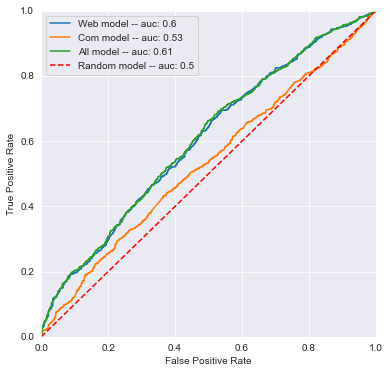

In [42]:
# get auc score of the web model
fpr_w, tpr_w, threshold = roc_curve(y_true=basetable_val["TARGET"], y_score=web_val_preds[:, 1])
auc_w = roc_auc_score(y_true=basetable_val["TARGET"], y_score=web_val_preds[:, 1])

# get auc score of the commercial model
fpr_c, tpr_c, threshold = roc_curve(y_true=basetable_val["TARGET"], y_score=com_val_preds[:, 1])
auc_c = roc_auc_score(y_true=basetable_val["TARGET"], y_score=com_val_preds[:, 1])

# get auc score of the complete model
fpr_a, tpr_a, threshold = roc_curve(y_true=basetable_val["TARGET"], y_score=all_val_preds[:, 1])
auc_a = roc_auc_score(y_true=basetable_val["TARGET"], y_score=all_val_preds[:, 1])

# create plot with roc curves of each model
plt.figure(figsize=(6, 6))
plt.plot(fpr_w, tpr_w, label="Web model -- auc: %s" %round(auc_w, 2))
plt.plot(fpr_c, tpr_c, label="Com model -- auc: %s" %round(auc_c, 2))
plt.plot(fpr_a, tpr_a, label="All model -- auc: %s" %round(auc_a, 2))
plt.plot([0, 1], [0, 1],'r--', label="Random model -- auc: 0.5")
plt.legend(loc = 'upper left')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The models trained on the features coming from the **web data** (Web model) and on **all the features** (All model) have the highest AUC. However, the model trained on the web data (Web model) has less features and hence is **less complex**. Therefore, we will choose the model trained on the web data as our final model (i.e., Occam's razor). We will **evaluate this model** on the test set to get our final unbiased estimate of the model performance.

# 7. Model Evaluation

**Exercise 8**:
    
Get the **predicted probabilities** for all the observations in the test set by using the best performing model.

In [43]:
# train final model on training set and get predictions on test set
final_model_test_preds = fit_lr_with_features(features = web_data_features, 
                                              dependent_variable = "TARGET",
                                              train_data = basetable_train,
                                              test_data = basetable_test)

## 7.1. AUC

**Exercise 9**:
    
Get the ``AUC`` of the **final model** on the test set and **plot** the ``ROC`` curve.

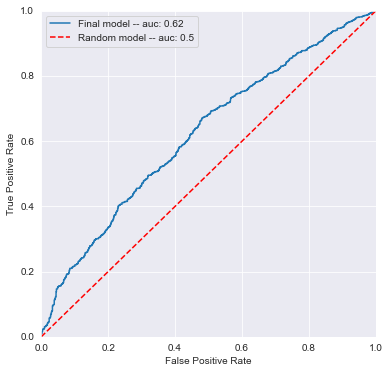

In [44]:
# get auc score of final model
fpr_f, tpr_f, threshold = roc_curve(y_true=basetable_test["TARGET"], y_score=final_model_test_preds[:, 1])
auc_f = roc_auc_score(y_true=basetable_test["TARGET"], y_score=final_model_test_preds[:, 1])

# create plot with roc curve
plt.figure(figsize=(6, 6))
plt.plot(fpr_f, tpr_f, label="Final model -- auc: %s" %round(auc_f, 2))
plt.plot([0, 1], [0, 1],'r--', label="Random model -- auc: 0.5")
plt.legend(loc = 'upper left')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 7.2. Lift

Finally, we will evaluate our model in terms of the ``lift``. This measures how much the model performs better than a random model **for different chunks of data**. More specifically, the observations are **first sorted** by their predicted probability of being positive (in this case being successfully converted into a customer). Next, these observations will be **grouped into different chunks** (most often into percentiles with each percentile containing 1% of the observations). So the first chunk will contain observations with higher predicted probabilites than the second chunk and so on, meaning that the model is more certain for making positive predictions in the first chunk than the second chunk and so on. So we can expect that the number of correctly identified positives in the first chunk will be higher than the second chunk and so on.
Finally, for each chunk, the model performance is **compared with the random model** by dividing the proportion of correctly identified positives with the general proportion of positives (which is the prediction of the random model). The result is a **lift score** for each chunk, indicating how much the model performs better than the random model for that particular chunk. 

For **example**: 
Suppose that there are 1000 companies in the test set and that the proportion of succesfully converted companies
equals 0.6.
First we will sort these companies by their predicted probability of being successfully converted into a customer.
Next we will split these ranked companies into percentiles, such that each chunk will contain 10 companies.
Now suppose that in the first chunk there are 9 companies of which the true label was 1 and 1 company of which the true label was 0. 
Then the lift score of this chunk is 0.9 / 0.6 = 1.5, meaning that the model is 1.5 times better than the random model for this chunk. 
Now suppose that in the second chunk there are only 7 companies of which the true label was 1 and 3 companies of which the true label was 0. 
Then the lift score of this chunk is 0.7 / 0.6 = 1.16, meaning that the model is 1.16 times better than the random model for this chunk.

<img src="./data/lift.png" width="500">

**Exercise 10**:
    
1) **Extract the label** and the **predicted probability** of being successfully converted into a customer of each observation in the test set and **store** these 2 variables into a new DataFrame.
        
2) **Sort** the observations of this new DataFrame by the predicted probability in *descending* order.
    
3) Get the **proportion** of companies being successfully converted in the test set.

In [45]:
# join dependent variable and predictions of test set
label_pred = pd.DataFrame({"TARGET": basetable_test["TARGET"],
                           "prediction": final_model_test_preds[:, 1]})

# sort DataFrame by predicted probability
label_pred = label_pred.sort_values(by="prediction", ascending=False)

# check
label_pred.head(5)

,TARGET,prediction
663,1,0.973327
7505,1,0.945001
4093,1,0.941766
6527,1,0.941583
8177,1,0.933764


In [46]:
# get global proportion of profitable customers in test set
prop_profitable_cust_test = label_pred["TARGET"].sum() / float(len(label_pred))
# check
print("Proportion of profitable customers: %s" %prop_profitable_cust_test)

Proportion of profitable customers: 0.6428295322767684


In [47]:
# calculate max lift
max_lift = 1. / prop_profitable_cust_test
# check
print("Max lift: %s" %max_lift)

Max lift: 1.555622369212267


**Exercise 11**:
    
Now that the companies are ranked according to their predicted probability of being successfully converted 
into a customer, we can calculated the lift score for each percentile. 
In the following code, companies are already properly assigned to each chunk by making use of a for loop.

1) Complete the code by **calculating the lift score for each chunk** and store this lift score in the ``lift_scores`` list.
        
        
2) **Plot the lift scores for each chunk** with the chunk number on the X-axis and the lift score on the Y-axis.

In [48]:
# initialize list for storing lift scores 
lift_scores = []

# loop through percentiles
for i in reversed(range(100)):
    # divide dataframes into percentiles of predicted probabilities
    start_perc = label_pred["prediction"].quantile(i / 100.)
    end_perc = label_pred["prediction"].quantile((i+1) / 100.)
    chunk = label_pred[(label_pred["prediction"] >= start_perc) &  (label_pred["prediction"] < end_perc)]
    
    # get size of chunk
    chunk_size = len(chunk)
    
    # get proportion of profitable customers in chunk
    prop_profitable_cust_chunk = chunk["TARGET"].sum() / float(chunk_size)
    
    # divide by global proportion of profitable customors
    lift = prop_profitable_cust_chunk / prop_profitable_cust_test
    
    # add to lift list
    lift_scores.append(lift)

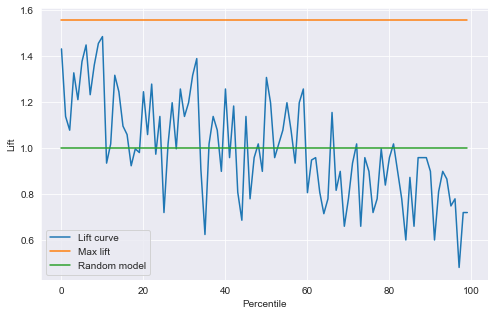

In [49]:
# plot lift curve
plt.figure(figsize=(8, 5))
plt.plot(range(100), lift_scores, label="Lift curve")
plt.plot(range(100), [max_lift for i in range(100)], label="Max lift")
plt.plot(range(100), [1 for i in range(100)], label="Random model")
plt.xlabel("Percentile")
plt.ylabel("Lift")
plt.legend(loc="lower left")
plt.show()